In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Train test split
from sklearn.model_selection import train_test_split

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Model hyperparameter tuning
from sklearn.model_selection import GridSearchCV 

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation Section -----
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
df = pd.read_csv("../datasets/water_fe.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
# drivers = df[['quantity','longitude_imputation','latitude_imputation','gps_height','waterpoint_type_group',
#              'extraction_type_class','construction_decade','amount_tsh','payment_type']]

# drivers = df[['longitude_imputation','latitude_imputation','quantity','gps_height','extraction_type_class',
#              'waterpoint_type_group','payment_type','funder_grouped','amount_tsh','source_type','population_original','age']]

# drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age','waterpoint_type_group',
#              'population_original','payment_type','source_type','amount_tsh','funder_grouped','installer_grouped']]

drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age',
                               'waterpoint_type_group','population_original','payment_type','source_type','amount_tsh','funder_grouped']]
target = df['outcome']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(drivers, 
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)

In [5]:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

___
# <ins>Model Building<ins>

In [6]:
# Random Forest Classification model initialisation
rf_clf = RandomForestClassifier(random_state=42)

# Random Forest Classification model's parameter grid
f_rf_search = GridSearchCV(rf_clf,
                            param_grid={'random_state': [42],
                                        'n_estimators': np.arange(64,128,8).tolist(),
                                        'max_features': ['auto', 'sqrt', 'log2'],
                                        'criterion' :['gini'],
                                        'class_weight' : ['balanced']
                                        },
                            scoring='accuracy',
                           verbose=3)

In [7]:
# Run fit with all sets of parameters
# Random Forest Classifier
f_rf_search.fit(Xs_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=64, random_state=42;, score=0.791 total time=   2.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=64, random_state=42;, score=0.790 total time=   2.2s
[CV 3/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=64, random_state=42;, score=0.797 total time=   2.1s
[CV 4/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=64, random_state=42;, score=0.798 total time=   2.1s
[CV 5/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=64, random_state=42;, score=0.792 total time=   2.2s
[CV 1/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=72, random_state=42;, score=0.792 total time=   2.4s
[CV 2/5] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=72, random_state=42;, score=0.79

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'], 'criterion': ['gini'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [64, 72, 80, 88, 96, 104, 112, 120],
                         'random_state': [42]},
             scoring='accuracy', verbose=3)

In [8]:
print("Best parameter for Random Forest Classification ", f_rf_search.best_params_)
print("Accuracy: ", f_rf_search.best_score_, "\n")

Best parameter for Random Forest Classification  {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 112, 'random_state': 42}
Accuracy:  0.7941708754208754 



              precision    recall  f1-score   support

           0       0.78      0.87      0.82      6452
           1       0.55      0.18      0.27       863
           2       0.80      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.71      0.61      0.63     11880
weighted avg       0.77      0.78      0.77     11880



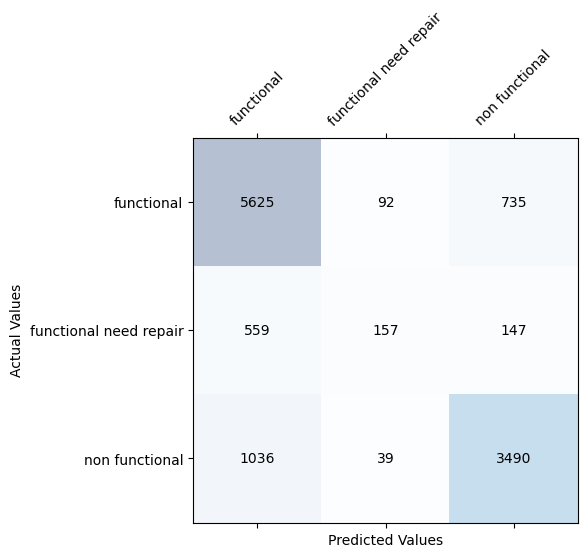

In [9]:
# Fit Random Forest Classification with the best parameter 
rf= RandomForestClassifier(**f_rf_search.best_params_)

rf.fit(Xs_train, y_train)
y_pred =rf.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

In [10]:
models = []
models.append(("Random Forest", rf))

# Test options and evaluation metric
num_folds = 5
num_instances = len(Xs_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, Xs_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-15s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest  : 0.793582 (0.002806)


---
## Final Model using entire dataset

In [11]:
# Initialise Random forest classifier with the best parameter
rf_model = RandomForestClassifier(**f_rf_search.best_params_)

# Normalise data
Xns = scaler.fit_transform(drivers)

# Train Random forest classifier with the entire dataset
rf_model.fit(Xns, target)

RandomForestClassifier(class_weight='balanced', n_estimators=112,
                       random_state=42)

In [12]:
# Save the model
import pickle

# Dump and save the Random Forest Classifier model
with open("RandomForestClassifier.pickle", "wb") as f:
    pickle.dump(rf_model, f)